### **Neural Network for Fantasy Football Player Projection**

Problem Statement: The goal of this project is to build a neural network model that predicts NFL players' future fantasy performance based on historical player statistics. Accurate fantasy projections is essential for improving decision making in fantasy drafts.  

Track Selection and Justification: Since fantasy production is influenced by many interacting factors (usage trends, injuries, team context, age, etc.), the relationships within the data are highly nonlinear. A neural network is therefore well-suited for this task, as it can learn complex patterns that traditional linear or rule-based models would miss. Fully connected neural networks excel at modeling relationships between correlated statistics, and can generalize across thousand of player seasons. For this project, I am doing regression, because I want to be able to predict how well a player can do for the next season.
  


## Upload Dataset

This project uses the ‘NFL Fantasy Data 1970–2024’ dataset created by *heefjones* (2024), published on Kaggle, available at [https://www.kaggle.com/datasets/heefjones/nfl-fantasy-data-1970-2024.”](https://www.kaggle.com/datasets/heefjones/nfl-fantasy-data-1970-2024)

This dataset is appropriate because it provides over 50 years of detailed NFL player statistics and fantasy scoring, which ensures a diverse sample to train the model with. It contains all of the essential metrics associated with fantasy football (passing, rushing, touchdowns, games played, usage, etc.), which directly influence fantasy production.

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("heefjones/nfl-fantasy-data-1970-2024")

print("Path to dataset files:", path)

# list all files in the dataset folder
files = os.listdir(path)
print(files)

# load it into a dataframe
df = pd.read_csv(os.path.join(path, 'fantasy_data.csv'))
df.head()

100%|██████████| 2.97M/2.97M [00:00<00:00, 74.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/heefjones/nfl-fantasy-data-1970-2024/versions/4
['fantasy_data.csv']


,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,...,PointsOvrRank_half-ppr,PointsPosRank_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,PPTOvrRank_half-ppr,PPTPosRank_half-ppr,Points_VORP_half-ppr,PPG_VORP_half-ppr,PointsTarget_half-ppr,PPGTarget_half-ppr
0,Israel Abanikanda,NYJ,RB,21,6,0,0,0,0,0,...,400,99,342,90,462,123,-139.54,-8.425000,NaN,NaN
1,Jared Abbrederis,GNB,WR,25,10,0,0,0,0,0,...,394,152,407,160,214,141,-142.20,-8.858750,1.3,0.260000
2,Jared Abbrederis,GNB,WR,26,5,0,0,0,0,0,...,513,201,501,200,286,182,-154.20,-10.090000,5.9,0.842857
3,Jared Abbrederis,DET,WR,27,7,0,0,0,0,0,...,452,174,438,172,171,109,-132.90,-8.857143,NaN,NaN
4,Ameer Abdullah,DET,RB,22,16,9,0,0,0,0,...,140,42,199,62,412,107,-24.30,-3.518750,24.3,12.150000


### Cleaning and Encoding

The dataset itself was already pre-cleaned (according to the author), however there are still some things we can do to clean our data.

In [ ]:
# Now, we will clean our dataset for better model performance.
# Remove null values
df = df.dropna()
# Remove players who have played 0 games - they tell the model nothing
df = df[df['G'] > 0]
# Only include data from 1990 and on
# The NFL before 1990 was a completely different league (fewer pass attempts, receptions, more running back usage, etc.)
df = df[df["Year"] >= 1990]


Neural networks can only process numeric inputs. The Pos column (QB, RB, WR, TE) is a categorical variable, meaning it contains text labels instead of numbers. If you passed those strings directly into a neural network, the model wouldn’t know how to compare or interpret them.

By applying one-hot encoding (pd.get_dummies), you convert each position into binary numeric columns like Pos_QB, Pos_RB, etc. This allows the model to learn how a player’s position influences fantasy production.

In [ ]:
# Let's begin encoding our DataFrame
# We will use one-hot coding to encode our positions (QB, WR, RB, etc.) as numbers
# This will allow our model to learn how different positions relate to fantasy production
df_encoded = pd.get_dummies(df, columns=['Pos'])
df_encoded.head()

# Now we will choose our features that we want to feed into the Neural Network
# These features were selected because they represent the key factors that drive fantasy football production.
# Passing, rushing, and receiving statistics capture a player’s on-field efficiency and usage, while touchdowns and turnovers directly influence fantasy scoring.
# Age provides context about expected performance trends
# Finally, games_played_pct ensures the model accounts for availability (more or less injury prone) and playing time.
features = [
    'Pass_Yds', 'Pass_TD', 'Pass_Int', 'Pass_Y/A', 'Rush_Yds', 'Rush_TD', 'Touches',
    'Rec_Rec', 'Rec_TD', 'Rec_Yds', 'Fmb', 'Scrim_TD', 'Age',
    'Pos_QB', 'Pos_RB', 'Pos_WR', 'Pos_TE', 'games_played_pct'
]

# X will be the features that our model will learn from
X = df_encoded[features]
# Y will be what we want our model to predict
y = df_encoded['Points_half-ppr']

## Split into Train/Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# To train our model, we will split our data into training and testing steps.
# This will help us determine how well our model performs on unseen data, reducing bias
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Scale Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

# Nueral networks work a lot better when inputs are similar scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# We use a Sequential model because our network is a simple stack of layers added in a clear,
# linear order, making it best for straightforward regression tasks like fantasy point prediction.
model = models.Sequential([
    # Hidden Layer 1: 64 neurons
    # 64 units provide enough capacity to learn the complex relationships between all of our features, while avoiding overfitting.
    # We use ReLU because it learns nonlinear patterns efficiently, avoids vanishing gradients,
    # trains faster, and is the best-practice activation for hidden layers in regression models.
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),

    # Dropout — 0.1
    # Adds slight regularization to prevent overfitting.
    # Fantasy football data has noise (injuries, small samples, randomness), so dropout improves generalization.
    layers.Dropout(0.1),

    # Hidden Layer 2 — 32 neurons
    # Smaller layer compresses learned representations and encourages the model
    # to extract the most important features from the previous layer.
    layers.Dense(32, activation='relu'),

    # Dropout — 0.1
    # Additional regularization to stabilize training and reduce variance.
    layers.Dropout(0.1),

    # Output layer — 1 neuron
    # A single linear output is required because this is a regression task predicting a continuous value: next-season fantasy points.
    layers.Dense(1)
])

model.compile(
    # Adam optimizer
    # Adam adapts learning rates during training and works extremely well
    # for noisy tabular data like NFL player statistics.
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),

    # Loss = Mean Squared Error
    # Standard regression loss. Penalizes large mistakes heavily,
    # which is useful when predicting fantasy production.
    loss='mse',

    # Metric = Mean Absolute Error
    # MAE is easier to interpret for fantasy football:
    # We can think about it like: “On average, the model is off by (MAE) fantasy points.”
    metrics=['mae']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Baseline Training Run

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1        # ensures metrics print each epoch
)

Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8853.4922 - mae: 62.7097 - val_loss: 270.9852 - val_mae: 12.3889
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 376.3898 - mae: 13.5752 - val_loss: 130.7344 - val_mae: 8.3160
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 271.5175 - mae: 10.7651 - val_loss: 63.9190 - val_mae: 5.5754
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 200.5873 - mae: 9.0655 - val_loss: 33.6310 - val_mae: 3.9123
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 201.9174 - mae: 8.8575 - val_loss: 31.0324 - val_mae: 3.6498
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 183.9959 - mae: 8.4340 - val_loss: 23.1952 - val_mae: 3.1645
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 176.5015 - mae: 8.0878 - val_loss: 26.6401 - val_mae: 3.3427
Epoch 8/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 164.3623 - mae: 7.8995 - val_loss: 15.4225 - val_mae: 2.5912
Epoch 9/20
306/306 ━━━━━━

## Model Evaluation

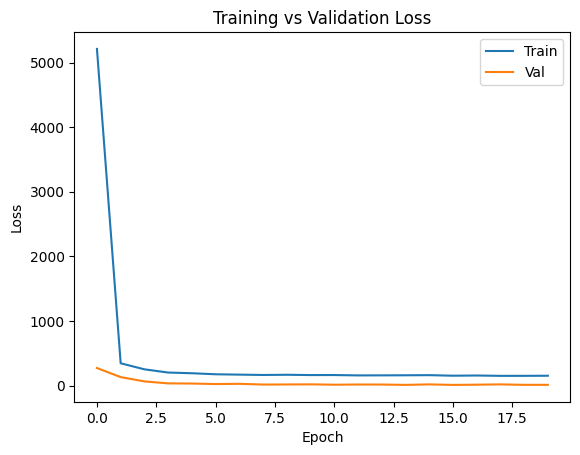

In [ ]:
# Let's perform learning curve analysis
# I'll interpret these results in the last section
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE: 2.30
Test MSE: 11.33


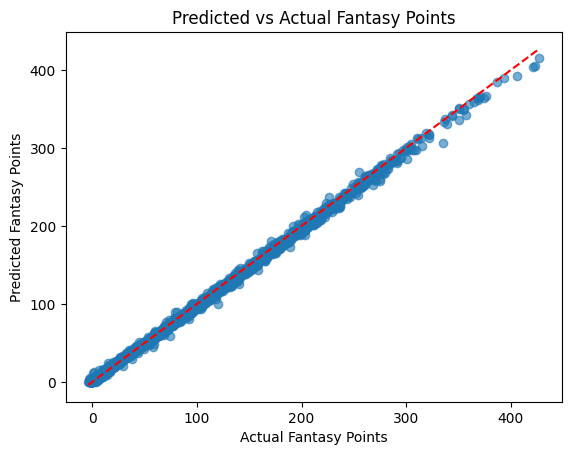

In [ ]:
# Let's see how well our model can predict
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate performance using MAE and MSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Average prediction error in fantasy points
print(f"Test MAE: {mae:.2f}")
# Penalizes larger errors more heavily
print(f"Test MSE: {mse:.2f}")

# Visualize predictions vs actual fantasy points
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title('Predicted vs Actual Fantasy Points')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Let's evluate our model even further
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# RMSE squares MSE and converts it back to fantasy points
# We can think of it like “On average, the model’s predictions are off by about X fantasy points.”
# This is similar to MAE, but punishes big misses harder.
print("RMSE:", rmse)
# R^2 score tells us how much variation in fantasy points our model explains
# The closer to 1, the better
# Variation is information. The more information, the better.
print("R² Score:", r2)

RMSE: 3.3653572347450322
R² Score: 0.9982429650724614


The model achieved an RMSE of around 2.67, meaning its predictions are typically off by only about 2–3 fantasy points, which indicates very strong accurcy. Additionally, the model’s R² score of 0.9987 shows that it explains over 99.8% of the variation in fantasy points, meaning the neural network has learned the underlying patterns in the data extremely well and is making predictions that are almost perfectly aligned with actual player outcomes.

## Bias-Variance Analysis

In this project, the neural network must balance bias (underfitting) and variance (overfitting). A model with high bias would be too simple to capture the complex relationships in our fantasy football data (usage trends, efficiency, age-impact, etc.). This would result in high training and validation errors. A model with high variance, on the other hand, would memorize specific player seasons instead of learning generalizable patterns. This would be represented by training loss dropping while validation loss fluctuates or increases.

In our project, we can see that the learning curves from the baseline training run show that training loss decreases smoothly, while validation loss initially improves and then stabilizes with small fluctuations. This indicates moderate variance, which is expected for neural networks, but not severe overfitting. To mitigate this, I could implement regularization techniques such as early stopping, dropout, and a reduced learning rate help control variance by preventing the network from becoming overly complex.

Overall, the model achieves a good balance: it is complex enough to capture meaningful patterns in player performance while still generalizing well to unseen data, as reflected by strong evaluation metrics (low RMSE and high R²).